# Project 3
The prediction of molecular properties is an important task in drug discovery. The molecules' atomic composition and arrangement can already tell us a lot about their biological behavior. Each 2D molecule can be represented as a graph, where the nodes are atoms connected by edges corresponding to chemical bonds. The prediction of molecular properties can be formulized as a graph classification task, and graph neural network is usually applied for making graph-level prediction.

In this project, you need develop a model for predicting the toxicity of new molecules. This notebook provides a sample pipeline that establishes a baseline. It is expected that your methods should outperform this baseline. You are strongly encouraged to think about designing more powerful models, finetuning hyperparameters, developing better training strategies, etc.

# Install package

In [2]:
# New these two packages
%pip install torch_geometric
%pip install rdkit-pypi
%pip install torch 

You should consider upgrading via the '/Users/minstonewang/Desktop/project-3/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/minstonewang/Desktop/project-3/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/minstonewang/Desktop/project-3/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Some tutorials.



1.   Pytorch geometric package: https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html
2.   PyTorch Geometric for Graph-Based Molecular Property Prediction using MoleculeNet benchmark: https://medium.com/@nikopavl4/pytorch-geometric-for-graph-based-molecular-property-prediction-using-moleculenet-benchmark-41e36369d3c6
3. Graph neural networks for graph classification. https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing
4. Related github repository on molecular property predictions. https://github.com/yifeiwang15/MotifConv/tree/main/MCM_for_molecule_benchmarks


## What are node and edge features in a molecule.

### Node features:

**Atomic number**: Number of protons in the nucleus of an atom. It’s characteristic of a chemical element and determines its place in the periodic table.

**Chirality**: A molecule is chiral if it is distinguishable from its mirror image by any combination of rotations, translations, and some conformational changes. Different types of chirality exist depending on the molecule and the arrangement of the atoms.

**Degree**: Number of directly-bonded neighbors of the atom.
Formal charge: Charge assigned to an atom. It reflects the electron count associated with the atom compared to the isolated neutral atom.

**Number of H**: Total number of hydrogen atoms on the atom.
Number of radical e: Number of unpaired electrons of the atom.

**Hybridization**: Atom’s hybridization.

**Is aromatic**: Whether it is included in a cyclic structure with pi bonds. This type of structure tends to be very stable in comparison with other geometric arrangements of the same atoms.

**Is in ring**: Whether it is included in a ring (a simple cycle of atoms and bonds in a molecule).

### Edge features:

**Bond type:**: Whether the bond is single, double, triple, or aromatic.

**Stereo Type:** Stereo configuration of the bond.

**Is conjugated**: Whether or not the bond is considered to be conjugated.



# Dataset preparation and train-valid splitting.

In [3]:
import torch
import torch_geometric
import numpy as np
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
from torch_geometric.datasets import MoleculeNet
import pickle

In [4]:
# Load datasets. The training and validation sets contain both molecules and their property labels. The test set only contain molecules.
# There are 12 property tasks for prediction. Some properties labels are missing (i.e., nan). You can ignore them.
train_dataset = torch.load("train_data.pt")
valid_dataset = torch.load("valid_data.pt")
test_dataset = torch.load("test_data.pt")

print(f'Size of training set: {len(train_dataset)}')
print(f'Size of validation set: {len(valid_dataset)}')
print(f'Size of test set: {len(test_dataset)}')

Size of training set: 6264
Size of validation set: 783
Size of test set: 784


In [5]:
# one graph example
g = train_dataset[0]
print(g)

print("Get node feature matrix:")
print(g.x)
print(g.x.shape) # (num_of_nodes, num_of_node_features)

print("Get edge index matrix:")
print(g.edge_index)
print(g.edge_index.shape) # (2, num_of_edges)

print("Get edge attribute matrix:")
print(g.edge_attr)
print(g.edge_attr.shape) # (num_of_edges, num_of_edge_features)

print("Get molecular property labels:")
print(g.y)
print(g.y.shape) # (1, 12)

Data(x=[11, 9], edge_index=[2, 20], edge_attr=[20, 3], y=[1, 12], smiles='CC(O)(P(=O)(O)O)P(=O)(O)O')
Get node feature matrix:
tensor([[ 6,  0,  4,  5,  3,  0,  4,  0,  0],
        [ 6,  0,  4,  5,  0,  0,  4,  0,  0],
        [ 8,  0,  2,  5,  1,  0,  4,  0,  0],
        [15,  0,  4,  5,  0,  0,  4,  0,  0],
        [ 8,  0,  1,  5,  0,  0,  3,  0,  0],
        [ 8,  0,  2,  5,  1,  0,  4,  0,  0],
        [ 8,  0,  2,  5,  1,  0,  4,  0,  0],
        [15,  0,  4,  5,  0,  0,  4,  0,  0],
        [ 8,  0,  1,  5,  0,  0,  3,  0,  0],
        [ 8,  0,  2,  5,  1,  0,  4,  0,  0],
        [ 8,  0,  2,  5,  1,  0,  4,  0,  0]])
torch.Size([11, 9])
Get edge index matrix:
tensor([[ 0,  1,  1,  1,  1,  2,  3,  3,  3,  3,  4,  5,  6,  7,  7,  7,  7,  8,
          9, 10],
        [ 1,  0,  2,  3,  7,  1,  1,  4,  5,  6,  3,  3,  3,  1,  8,  9, 10,  7,
          7,  7]])
torch.Size([2, 20])
Get edge attribute matrix:
tensor([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
 

As we can observe, we have 11 nodes (rows) and each node has 9 features (columns). However, the features provided by Moleculenet are discrete and of type long, so we need to convert them first to continuous embeddings in order to feed them in any ML model.

For example, the first column indicates the atomic number of a node, where 1 represents Hydrogen, 6 represents Carbon, 8 for Oxygen, according to periodic table of elements.

In [6]:
# Example of preparing data loaders.
# You can use any batch size and see what happens in model performance.

from torch_geometric.data import DataLoader

batch_size=64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/Users/minstonewang/Desktop/project-3/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [7]:
# Example of creating one mini-batch
# See more info about mini-batch in pytorch geometric in https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html
batch = next(iter(train_loader))
print(batch)

DataBatch(x=[1105, 9], edge_index=[2, 2250], edge_attr=[2250, 3], y=[64, 12], smiles=[64], batch=[1105], ptr=[65])


# Visualization of molecules

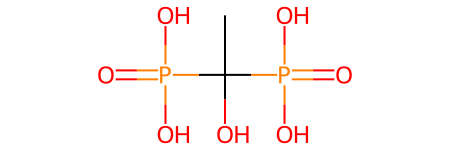

In [8]:
# visualize one 2D molecule.
from rdkit import Chem
Chem.MolFromSmiles(g.smiles)

### Calculate weights for each class 

In [9]:
import numpy as np
# Assuming there are 12 properties, initialize an array to store counts for each property
property_counts = np.zeros(12)

# Iterate over the dataset to count each property
for graph in train_dataset:
    labels = graph.y
    for i in range(12):
        if not torch.isnan(labels[0, i]):
            property_counts[i] += labels[0, i]

# Calculate class weights
# The weight for each class is inversely proportional to its frequency
class_weights = [1.0 / count if count > 0 else 0 for count in property_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Handle the case where a class is not present in the dataset (to avoid division by zero)
class_weights[class_weights == float('inf')] = 0

print("Class weights:", class_weights)

Class weights: tensor([0.0040, 0.0053, 0.0017, 0.0048, 0.0015, 0.0034, 0.0075, 0.0014, 0.0051,
        0.0035, 0.0014, 0.0036])


In [10]:
import torch.nn.functional as F

def weighted_binary_cross_entropy(output, target, weights=None):
    # output = torch.sigmoid(output)
    if weights is not None:
        # Apply weights to the loss
        # loss = F.binary_cross_entropy(output, target, reduction='none')
        # loss = weights * loss
        loss = torch.nn.BCEWithLogitsLoss(weight=weights)(output, target)
        return loss.mean()
    else:
        loss = F.binary_cross_entropy(output, target, reduction='none')
    return torch.mean(torch.sum(loss, dim=1))

In [11]:
from torch_geometric.loader import DataLoader
import molvs as mv
import numpy as np
import torch
from rdkit import Chem
from rdkit.Chem import AllChem

batch_size=64

new_train_dataset = []	
 # Remove data that has nan values
for data in train_dataset:
    y = data.y.numpy()
    has_nan = np.isnan(y).any()
    if not has_nan:
        new_train_dataset.append(data)
        

# Your existing functions:
def parent(smiles):
    st = mv.Standardizer()
    try:
        mols = st.charge_parent(Chem.MolFromSmiles(smiles))
        return Chem.MolToSmiles(mols)
    except:
        return "NaN"

def morgan_fp(smiles, radius=3, n_bits=8192):
    standardized_smiles = parent(smiles)
    if standardized_smiles != "NaN":
        mol = Chem.MolFromSmiles(standardized_smiles)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        return np.array(list(fp.ToBitString())).astype('int')
    else:
        return np.zeros(n_bits, dtype='int')

for dataset in [train_dataset, valid_dataset, test_dataset]:
    for data in dataset:
        smiles = data.smiles
        fp_array = morgan_fp(smiles)
        data.fp = torch.tensor(fp_array, dtype=torch.float)  # Adding fingerprint data as a new attribute


[16:12:26] WARNING: not removing hydrogen atom without neighbors
[16:12:26] WARNING: not removing hydrogen atom without neighbors
[16:12:26] Explicit valence for atom # 1 B, 5, is greater than permitted
[16:12:29] Explicit valence for atom # 1 B, 5, is greater than permitted
[16:12:46] Can't kekulize mol.  Unkekulized atoms: 3 10
[16:12:46] Can't kekulize mol.  Unkekulized atoms: 3 10


# Build model

In [12]:
# Atom encoder
class AtomEncoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(AtomEncoder, self).__init__()

        self.embeddings = torch.nn.ModuleList()

        for i in range(9):
            self.embeddings.append(torch.nn.Embedding(100, hidden_channels))

    def reset_parameters(self):
        for embedding in self.embeddings:
            embedding.reset_parameters()

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(1)

        out = 0
        for i in range(x.size(1)):
            out += self.embeddings[i](x[:, i])
        return out

# A simple graph neural network model

import torch
import torch.nn.functional as F
from torch_geometric.nn import GraphConv, global_mean_pool as gap
from torch.nn import Linear, BatchNorm1d

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, num_classes, fingerprint_dim, dropout_rate, reduction_dim=180):
        super(GNN, self).__init__()
        self.emb = AtomEncoder(hidden_channels=hidden_channels)
        self.conv1 = GraphConv(hidden_channels, hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm1d(hidden_channels)

        self.fp_lin = Linear(fingerprint_dim, hidden_channels)  
        # self.lin = Linear(2 * hidden_channels, num_classes)

        self.reduction_layer = Linear(2 * hidden_channels, reduction_dim)  # 256 is the concatenated size
        self.lin = Linear(reduction_dim, num_classes)
        self.dropout_rate = dropout_rate

    def forward(self, batch):
        x, edge_index, batch_size = batch.x, batch.edge_index, batch.batch
        fp = batch.fp  # Fingerprint data

        # Process graph data
        x = self.emb(x)
        x = self.conv1(x, edge_index)
        x = F.relu(self.bn1(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(self.bn2(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = gap(x, batch_size)  # Global Mean Pooling

        # Reshape or slice the fingerprint data to match batch size
        if fp.ndim == 1:
            fp = fp.view(-1, 8192)  # Assuming 8192 is the fingerprint size
        elif fp.ndim == 2 and fp.shape[0] != x.shape[0]:
            # Adjust according to your data's batching logic
            fp = fp.view(-1, 8192)

        fp = self.fp_lin(fp)
        # print(x.shape)
        # Concatenate graph features and fingerprint features
        x = torch.cat((x, fp), dim=1)
        x = self.reduction_layer(x)
        # print(x.shape)
        # Final layers
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.lin(x)

        return x



# Start training

### Train and Evaluate Functions

In [13]:
# loss function and optimizer
import torch.nn as nn
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss(reduction = "none")

# train and eval function
from sklearn.metrics import roc_auc_score
def train(model, device, loader, optimizer):
    model.train()

    for step, batch in enumerate(loader):
        batch = batch.to(device)
        pred = model(batch)
        y = batch.y.view(pred.shape).to(torch.float64)

        ## ignore nan targets (unlabeled) when computing training loss.
        is_labeled = batch.y == batch.y
        y_new = torch.where(torch.isnan(batch.y), torch.tensor(0.0, device=batch.y.device), batch.y)
        loss = weighted_binary_cross_entropy(pred, y_new, class_weights)
        # loss = criterion(pred.to(torch.float32)[is_labeled], batch.y.to(torch.float32)[is_labeled]).mean()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def eval(model, device, loader):
    model.eval()
    y_true = []
    y_pred = []
    # For every batch in test loader
    for batch in loader:

        batch = batch.to(device)
        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred = model(batch)

            y_true.append(batch.y.view(pred.shape))
            y_pred.append(pred)

    y_true = torch.cat(y_true, dim = 0).numpy()
    y_pred = torch.cat(y_pred, dim = 0).numpy()
    # Compute the ROC - AUC score and store as history
    rocauc_list = []

    for i in range(y_true.shape[1]):
        #AUC is only defined when there is at least one positive data.
        if np.sum(y_true[:,i] == 1) > 0 and np.sum(y_true[:,i] == 0) > 0:
            # ignore nan values
            is_labeled = y_true[:,i] == y_true[:,i]
            rocauc_list.append(roc_auc_score(y_true[is_labeled,i], y_pred[is_labeled,i]))

    if len(rocauc_list) == 0:
        raise RuntimeError('No positively labeled data available. Cannot compute ROC-AUC.')

    return {'rocauc': sum(rocauc_list)/len(rocauc_list)}


### Training Loop and functions

In [14]:
# Training function
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

#! 0.7855057617944571
def run_model(learning_rate, hidden_channels, dropout_rate, num_epochs=20, weight_decay=0.001):
    model = GNN(hidden_channels=hidden_channels, num_classes=12, fingerprint_dim=8192, dropout_rate=dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    best_metric = 0.7855057617944571
    
    print("Start training...")

    for epoch in range(1, num_epochs + 1):
        print("====epoch " + str(epoch))

        # Training
        train(model, device, train_loader, optimizer)
        
        # Evaluating
        train_acc = eval(model, device, train_loader)
        val_acc = eval(model, device, val_loader)
        print({'Train': train_acc, 'Validation': val_acc})

        if val_acc["rocauc"] > best_metric:  
            best_metric = val_acc["rocauc"]
            print(f'New best performance: {best_metric}')
            # Save the best model
            torch.save(model.state_dict(), "best_model.pt")
    
    return best_metric

In [15]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

import numpy as np

# Assuming `dataset` is your full dataset
kf = KFold(n_splits=5, shuffle=True, random_state=42)
splits = kf.split(np.arange(len(new_train_dataset)))


In [18]:
def cross_validate(learning_rate, hidden_channels, dropout_rate, num_epochs=20, weight_decay=0.001, dataset=new_train_dataset):
    roc_auc_scores = []
    fold = 1	
    print("Start training...")
    labels = [data.y for data in dataset]
    print(len(labels))
    print(labels)
    # stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # # The split method requires the class labels to stratify the data
    # splits = stratified_kf.split(np.arange(len(dataset)), labels)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    splits = kf.split(np.arange(len(new_train_dataset)))
    
    

    for train_idx, val_idx in splits:
      
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)
        

        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

        model = GNN(hidden_channels=64, num_classes=12, fingerprint_dim=8192, dropout_rate=0.6)
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

        
        for epoch in range(1, num_epochs + 1):
            print("====epoch " + str(epoch))

            # Training
            train(model, device, train_loader, optimizer)
            
            # Evaluating
            train_acc = eval(model, device, train_loader)
            val_acc = eval(model, device, val_loader)
            print({'Train': train_acc, 'Validation': val_acc})
            roc_auc_scores.append(val_acc["rocauc"])
            # if val_acc["rocauc"] > best_metric:  
            #     best_metric = val_acc["rocauc"]
            #     print(f'New best performance: {best_metric}')
            #     # Save the best model
            #     torch.save(model.state_dict(), "best_model.pt")
        fold += 1	


    # return np.mean(roc_auc_scores), np.std(roc_auc_scores)


In [20]:
import random 
param_dist = {
    'hidden_channels': [128],
    'dropout_rate': [0.6], 
    'learning_rate': [0.0001],
}

params = {k: random.choice(v) for k, v in param_dist.items()}
# avg_roc_auc, std_dev = cross_validate(**param_dist)
cross_validate(**param_dist)
# print(f"Average ROC-AUC across folds: {avg_roc_auc}, Std Dev: {std_dev}")


Start training...
2706
[tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]), tensor([[0., 0.,

In [ ]:
import random 
 
# param_dist = {
#     'hidden_channels': [128],
#     'dropout_rate': [0.6], 
#     'learning_rate': [0.01, 0.001, 0.0001],
#     'weight_decay': [5e-4, 5e-5, 5e-6]
# }

param_dist = {
    'hidden_channels': [128],
    'dropout_rate': [0.6], 
    'learning_rate': [0.001],
    'weight_decay': [5e-5],
    'num_epochs': [100]
}

num_iterations = 1
best_model = None	

for i in range(num_iterations):
    print(f'Iteration {i+1}/{num_iterations}')
    print('Hyperparameters:')
    params = {k: random.choice(v) for k, v in param_dist.items()}
    print(f'''{params}''')

    best_metric = run_model(**params)
    print('Best Performance:', best_metric)
    
torch.save(best_model.state_dict(), "model.pt")

Iteration 1/1
Hyperparameters:
{'hidden_channels': 128, 'dropout_rate': 0.6, 'learning_rate': 0.001, 'weight_decay': 5e-05, 'num_epochs': 100}
Start training...
====epoch 1
{'Train': {'rocauc': 0.7022333504830081}, 'Validation': {'rocauc': 0.6844909043714087}}
====epoch 2
{'Train': {'rocauc': 0.7033382030184288}, 'Validation': {'rocauc': 0.6811401383840123}}
====epoch 3
{'Train': {'rocauc': 0.7267873018843987}, 'Validation': {'rocauc': 0.6973958879350829}}
====epoch 4
{'Train': {'rocauc': 0.7324389979486859}, 'Validation': {'rocauc': 0.7051545333883059}}
====epoch 5
{'Train': {'rocauc': 0.7329845569000639}, 'Validation': {'rocauc': 0.7021254501219699}}
====epoch 6


[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 